## A brief introduction and background about AI4PDEs

The AI4PDEs code solves discretised systems with untrained neural networks. It is used to simulate incompressible Navier-Stokes equations which can be written in 2D as, 
$$
\frac{\partial \mathbf{q}}{\partial t} + u\frac{\partial \mathbf{q}}{\partial x} +  v\frac{\partial \mathbf{q}}{\partial y} + 
\sigma \mathbf{q} - \nu \nabla \cdot \nabla \mathbf{q} = -\nabla p \,
$$

$$
\nabla  \cdot \mathbf{q} = \mathbf{0} \,
$$
in which $\mathbf{q}=(u \;v)^T$ in 2D and $\mathbf{q}=(u\;v\;w)^T$ in 3D, $p$ is the pressure, $\sigma$ is an absorption term and $\nu$ is the viscosity coefficient. A projection based solution method formed by manipulating the 
discretised equations which results in the following procedure,
1. Solve for $\mathbf{q}^{n+1}$ using the two-step approach outlined for the Burgers and advection-diffusion equation but treating the term involving $\sigma$ fully implicitly:
$$
\frac{\mathbf{q}^{n+1} -\mathbf{q}^{n} }{\Delta t} + u^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial x} +  v^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial y} + 
\sigma \mathbf{q}^{n+1} - \nu \nabla \cdot \nabla \mathbf{q}^{n+\frac{1}{2}} = -\nabla p^n \,
$$
2. Solve for pressure correction $\Delta p$:
$$ 
\nabla^2 \Delta p = -\frac{1}{\Delta t} \nabla \cdot \mathbf{q}^{n+1}  
$$
3. Solve for the velocity correction $\Delta \mathbf{q}$ using the U-net structured multigrid solver
$$
\Delta \mathbf{q} = -\Delta t \nabla \Delta p. 
$$
4. Update pressure solution: $p^{n+1} = p^n + \Delta p$
5. Update velocity solution: $\mathbf{q}^{n+1} \leftarrow \mathbf{q}^{n+1} + \Delta \mathbf{q}$

## More details can be found in our recent publications,
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the discretised neutron diffusion equations using neural networks](https://doi.org/10.1002/nme.7321). International Journal for Numerical Methods in Engineering. 2023 Nov 15;124(21):4659-86. 
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the Discretised Boltzmann Transport Equations using Neural Networks: Applications in Neutron Transport](https://doi.org/10.48550/arXiv.2301.09991). arXiv preprint arXiv:2301.09991. 2023 Jan 24. 
+
Chen B, Heaney CE, Pain CC. [Using AI libraries for Incompressible Computational Fluid Dynamics](https://doi.org/10.48550/arXiv.2402.17913). arXiv preprint arXiv:2402.17913. 2024 Feb 27. 
+
Chen B, Heaney CE, Gomes JL, Matar OK, Pain CC. [Solving the Discretised Multiphase Flow Equations with Interface Capturing on Structured Grids Using Machine Learning Libraries]( https://doi.org/10.1016/j.cma.2024.116974). Computer Methods in Applied Mechanics and Engineering. 2024 June 1; 426: 0045-7825.

Contact: Prof Christopher C. Pain (c.pain@imperial.ac.uk), Dr Claire E. Heaney (c.heaney@imperial.ac.uk), Dr Boyang Chen (boyang.chen16@imperial.ac.uk). [Applied Modelling and Computation Group](https://www.imperial.ac.uk/earth-science/research/research-groups/amcg/), Department of Earth Science and Engineering, Imperial College London

## Load modules from Python/Pytorch

In [1]:
import os
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(is_gpu)

True


## Load modules from AI4PDEs

In [2]:
from AI4PDEs_utils  import create_tensors_3D, create_tensors_2D, get_weights_linear_2D, create_solid_body_2D
from AI4PDEs_bounds import boundary_condition_2D_u, boundary_condition_2D_v
from AI4PDEs_bounds import boundary_condition_2D_p, boundary_condition_2D_cw

## Initialise numerical parameter

In [3]:
dt = 0.05                               # Time step (s)
dx = 1.0 ; dy = 1.0                     # Grid size (m)
Re = 1.0                                # Viscosity 
ub = -1.0                               # Inflow speed (m/s)
nx = 256 ; ny = 256                     # Grid point
lx = dx * nx ; ly = dy * ny             # Domain size (m)
nlevel = int(math.log(ny, 2)) + 1       # Multigrid level
ntime = 500                             # Time step
n_out = 100                             # Time step to save results 
bias_initializer = torch.tensor([0.0])  # Initial bias as 0 for NNs 

## Initialise numerical parameter

In [4]:
[w1, w2, w3, wA, w_res, diag] = get_weights_linear_2D(dx)

All the required 2D filters have been created successfully!
w1    => second order derivative  - (1,1,3,3)
w2    => first order derivative x - (1,1,3,3)
w3    => first order derivative y - (1,1,3,3)
wA    => second order derivative  - (1,1,3,3)
w_res => Restriction operation    - (1,1,3,3)
diag  => Diagonal component of wA - (1,1,1,1)


## Establish AI4CFD Neural Network

In [5]:
class AI4CFD(nn.Module):
    """docstring for AI4CFD"""
    def __init__(self):
        super(AI4CFD, self).__init__()
        # self.arg = arg
        self.xadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.yadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.diff = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.A = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.res = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=0)  
        self.prol = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),)
        
        self.xadv.weight.data = w2
        self.yadv.weight.data = w3
        self.diff.weight.data = w1
        self.A.weight.data = wA
        self.res.weight.data = w_res

        self.xadv.bias.data = bias_initializer
        self.yadv.bias.data = bias_initializer
        self.diff.bias.data = bias_initializer
        self.A.bias.data = bias_initializer
        self.res.bias.data = bias_initializer
        
    def forward(self, values_u, values_uu, b_uu, dt):  
        values_uu = F.pad(values_u, (1, 1, 1, 1), mode='constant', value=0)
        ADx_u = self.xadv(values_uu) ; ADy_u = self.yadv(values_uu) ; AD2_u = self.diff(values_uu) 
    # First step for solving uvw
        b_u = values_u + 0.5 * (Re * AD2_u * dt - ub * ADx_u * dt - ub * ADy_u * dt)
    # Padding velocity vectors 
        b_uu = F.pad(b_u, (1, 1, 1, 1), mode='constant', value=0)
        ADx_u = self.xadv(b_uu) ; ADy_u = self.yadv(b_uu) ; AD2_u = self.diff(b_uu) 
    # Second step for solving uvw   
        values_u = values_u + Re * AD2_u * dt - ub * ADx_u * dt - ub * ADy_u * dt 
        return values_u

## Send the model to GPU

In [6]:
AI4CFD = AI4CFD().to(device)

## Create initial tensors 

In [7]:
values_u, values_v, values_p, values_uu, values_vv, values_pp, b_uu, b_vv = create_tensors_2D(nx, ny)

All the required 2D tensors have been created successfully!
values_u  => u velocity [first step]  - (1,1,ny,nx)
values_v  => v velocity [first step]  - (1,1,ny,nx)
values_p  => pressure                 - (1,1,ny,nx)
b_uu      => v velocity [second step] - (1,1,ny+2,nx+2)
b_vv      => v velocity [second step] - (1,1,ny+2,nx+2)
values_uu => u velocity [first step]  - (1,1,ny+2,nx+2)
values_vv => v velocity [first step]  - (1,1,ny+2,nx+2)
values_pp => pressure                 - (1,1,ny+2,nx+2)


## Initilise source

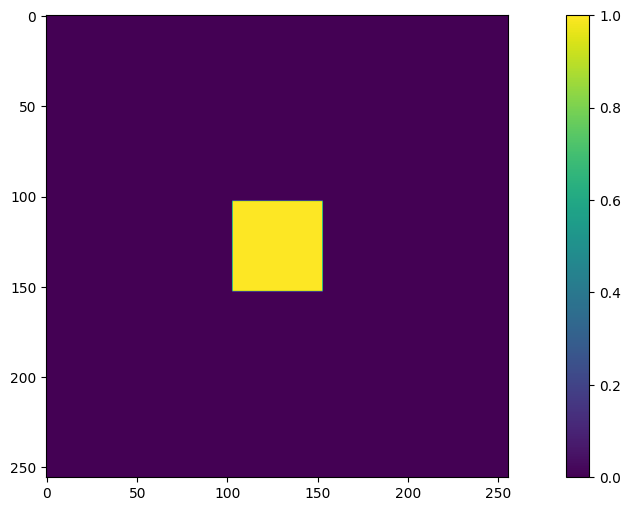

In [8]:
values_u[0,0,int(ny/2)-25:int(ny/2)+25,int(ny/2)-25:int(ny/2)+25] = 1
plt.figure(figsize=(15, 6))
plt.imshow(values_u[0,0,:,:].cpu())
plt.colorbar()

## Run AI4CFD solver

In [9]:
start = time.time()
print("=====================================================================")
print("Welcome to AI4CFD solver that will adv-diff problem solution for you!")
print("=====================================================================")
print("Summarising basic numerical setup before running AI4CFD code..........")
print(f'advection speed ------------------- {-ub} (m/s)')
print(f'Time step ------------------------- {dt} (s)')
print(f'Grid size ------------------------- {dx} (m)')
print("======================================================================")
print("Hello World, AI4CFD is running now!")
with torch.no_grad():
    for itime in range(1,ntime+1):
        values_u = AI4CFD(values_u,values_uu,b_uu,dt)
        print('Time step:', itime)
end = time.time()
print('Elapsed time:', end - start)
print("Goodbye World, AI4CFD is sleeping now!")

Welcome to AI4CFD solver that will adv-diff problem solution for you!
Summarising basic numerical setup before running AI4CFD code..........
advection speed ------------------- 1.0 (m/s)
Time step ------------------------- 0.05 (s)
Grid size ------------------------- 1.0 (m)
Hello World, AI4CFD is running now!
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
Time step: 20
Time step: 21
Time step: 22
Time step: 23
Time step: 24
Time step: 25
Time step: 26
Time step: 27
Time step: 28
Time step: 29
Time step: 30
Time step: 31
Time step: 32
Time step: 33
Time step: 34
Time step: 35
Time step: 36
Time step: 37
Time step: 38
Time step: 39
Time step: 40
Time step: 41
Time step: 42
Time step: 43
Time step: 44
Time step: 45
Time step: 46
Time step: 47
Time step: 48
Time step: 49
Time step: 

## Visualise sourece transportation

Text(0.5, 1.0, 'sourece after 500 time steps')

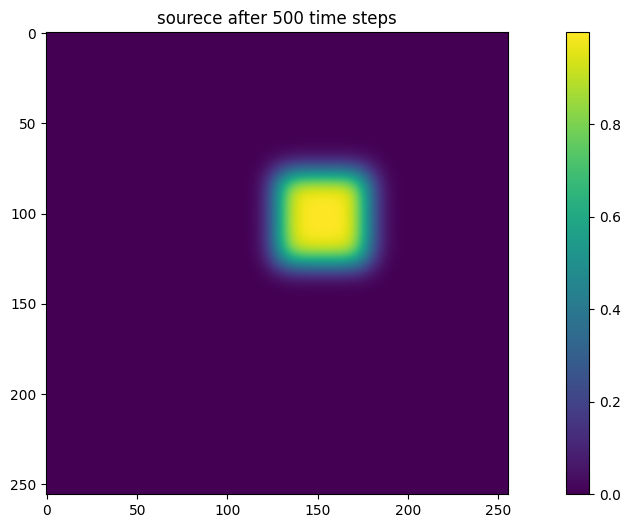

In [10]:
plt.figure(figsize=(15, 6))
plt.imshow(values_u[0,0,:,:].cpu())
plt.colorbar()
plt.title(f'sourece after {ntime} time steps')